In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from ArmaGarch import *
import numpy as np
import math
from scipy.special import gamma
from scipy.optimize import minimize

C:\Users\ANTOINE\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


## S&P 500

Extract the data from the files and plot it

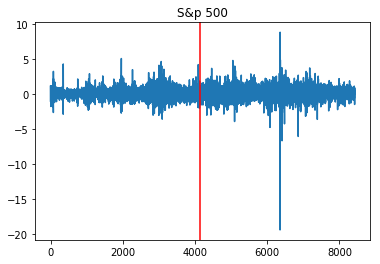

The size of training sample is 4133 and size of test sample is 4298


In [2]:
ysandp = []
with open ('S&P500.txt', 'rt') as myfile:
    for line in myfile:
        ysandp.append(float(line)*100)
plt.plot(ysandp)
plt.title('S&p 500')
plt.axvline(x=4133,color='red')
plt.show()
ysandp_in_sample = ysandp[:4133]
ysandp_out_sample = ysandp[4133:]
print('The size of training sample is',len(ysandp_in_sample),'and size of test sample is',len(ysandp_out_sample))

## Model selection

#### ARMA($p_m,q_m$)-GARCH($p_v,q_v$)

$y_t  = \mu_t + h_t \xi_t \\
\mu_t = \mu + \sum_{i=1}^{p_m} \phi_i y_{t-1} + \sum_{i=1}^{q_m} \theta_i \xi_{t-1} \\
h_t^2 = \omega + \sum_{i=1}^{p_v} \alpha_i y_{t-1}^2 + \sum_{i=1}^{q_v} \beta_i h_{t-1}^2$

#### We first try with a Gaussian ARMA($p_m,q_m$)-GARCH($p_v,q_v$)

We select the best model with respect to BIC

In [3]:
best = np.inf
param = []
for pm in [0,1,2]:
    for qm in [0,1,2]:
        for pv in [0,1,2]:
            for qv in [0,1,2]:
                model = ArmaGarch(pm=pm,qm=qm,pv=pv,qv=qv,dist='gaussian')
                model.fit(ysandp_in_sample)
                print("For ARMA(%i,%i)-GARCH(%i,%i) AIC is %0.2f and BIC is %0.2f" %(pm,qm,pv,qv,model.AIC,model.BIC))
                if (model.BIC < best):
                    param = [pm,qm,pv,qv]
                    best = model.BIC
print ('\n\nThe best model is ARMA(%i,%i)-GARCH(%i,%i) with BIC of %0.2f' %(param[0],param[1],param[2],param[3],best))

For ARMA(0,0)-GARCH(0,0) AIC is 9978.22 and BIC is 9990.87
For ARMA(0,0)-GARCH(0,1) AIC is 9455.41 and BIC is 9466.06
For ARMA(0,0)-GARCH(0,2) AIC is 9458.58 and BIC is 9475.56
For ARMA(0,0)-GARCH(1,0) AIC is 9185.53 and BIC is 9196.18
For ARMA(0,0)-GARCH(1,1) AIC is 8224.63 and BIC is 8241.61
For ARMA(0,0)-GARCH(1,2) AIC is 8419.78 and BIC is 8443.09
For ARMA(0,0)-GARCH(2,0) AIC is 9047.32 and BIC is 9064.30
For ARMA(0,0)-GARCH(2,1) AIC is 8218.54 and BIC is 8241.85
For ARMA(0,0)-GARCH(2,2) AIC is 8208.65 and BIC is 8238.29
For ARMA(0,1)-GARCH(0,0) AIC is 9837.77 and BIC is 9856.75
For ARMA(0,1)-GARCH(0,1) AIC is 9222.10 and BIC is 9239.08
For ARMA(0,1)-GARCH(0,2) AIC is 9226.57 and BIC is 9249.88
For ARMA(0,1)-GARCH(1,0) AIC is 9039.21 and BIC is 9056.19
For ARMA(0,1)-GARCH(1,1) AIC is 7944.08 and BIC is 7967.39
For ARMA(0,1)-GARCH(1,2) AIC is 8097.25 and BIC is 8126.88
For ARMA(0,1)-GARCH(2,0) AIC is 8891.78 and BIC is 8915.09
For ARMA(0,1)-GARCH(2,1) AIC is 7969.90 and BIC is 7999.

With respect to BIC criterion, the best model is a ARMA(0,1)-GARCH(1,1). So we keep this model to train and test our probability integram transform on out sample

In [4]:
model = ArmaGarch(qm=1,pv=1,qv=1,dist='gaussian')
model.fit(ysandp_in_sample)
model.show()

                 ARMA(0,1)-GARCH(1,1)
Distribution           Normal
Standard deviation     0.96
Method                 Maximum Likelihood
Optimization method    Nelder-Mead
Sucess                 True
Log Likelihood         -3967.042020987171
AIC                    7944.084041974342
BIC                    7967.391077232389
                       Coeffs
--------------------Mean Model------------------
theta[0]   0.2555273437499999
-----------------Volatility Model---------------
omega      0.006953475275568938
alpha[0]   0.11913311641542426
beta[0]    0.8808667833316336


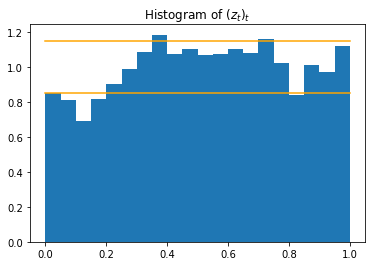

In [5]:
sigma2 = model.garch_filter(model.w,model.alpha,model.beta,ysandp_out_sample)
mu = model.arma_filter(model.phi,model.theta,ysandp_out_sample)
z_gauss = []
for i in range(len(ysandp_out_sample)):
    z_gauss.append(stats.norm.cdf(ysandp_out_sample[i], loc = mu[i] , scale = pow(sigma2[i],1/2)))
plt.hist(z_gauss,bins=20,density=True)
plt.plot([0,1],[1.15,1.15] , color = 'orange')
plt.plot([0,1],[0.85,0.85] , color = 'orange')
plt.title('Histogram of $(z_t)_t$')
plt.show()

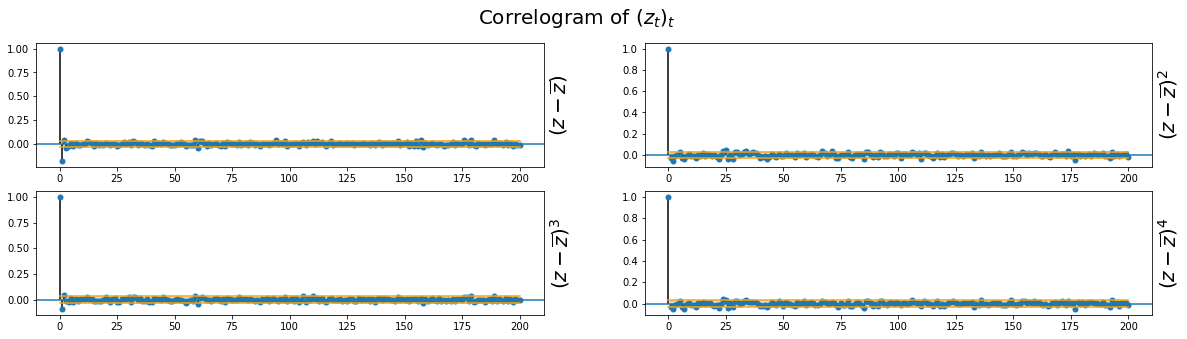

In [6]:
z_mean = sum(z_gauss)/len(z_gauss)
z1 = z_gauss-z_mean
z2 = pow(z_gauss-z_mean,2)
z3 = pow(z_gauss-z_mean,3)
z4 = pow(z_gauss-z_mean,4)
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(20,5))
plt.suptitle('Correlogram of $(z_t)_t$',size=20)
plot_acf(z1,lags=200,ax=ax[0,0],title="")
ax[0,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,0].set_ylabel('$(z- \overline{z})$', fontsize = 20 )#ylabel
ax[0,0].yaxis.set_label_position("right")
plot_acf(z2,lags=200,ax=ax[0,1],title="")
ax[0,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,1].set_ylabel('$(z- \overline{z})^2$', fontsize = 20 )#ylabel
ax[0,1].yaxis.set_label_position("right")
plot_acf(z3,lags=200,ax=ax[1,0],title="")
ax[1,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,0].set_ylabel('$(z- \overline{z})^3$', fontsize = 20 )#ylabel
ax[1,0].yaxis.set_label_position("right")
plot_acf(z4,lags=200,ax=ax[1,1],title="")
ax[1,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,1].set_ylabel('$(z- \overline{z})^4$', fontsize = 20 )#ylabel
ax[1,1].yaxis.set_label_position("right")
plt.show()

Gaussian MA(1)-GARCH(1,1) works well on the auto correlation but not on this distribution. So we try a $\mathcal{T}-Student$

#### Then with a $\mathcal{T}-Student$ Arma($p_m,q_m$)-Garch($p_v,q_v$)

In [7]:
best = np.inf
param = []
for pm in [0,1,2]:
    for qm in [0,1,2]:
        for pv in [0,1,2]:
            for qv in [0,1,2]:
                model = ArmaGarch(pm=pm,qm=qm,pv=pv,qv=qv,dist='student')
                model.fit(ysandp_in_sample)
                print("For ARMA(%i,%i)-GARCH(%i,%i) AIC is %0.2f and BIC is %0.2f" %(pm,qm,pv,qv,model.AIC,model.BIC))
                if (model.BIC < best):
                    param = [pm,qm,pv,qv]
                    best = model.BIC
print ('The best model is ARMA(%i,%i)-GARCH(%i,%i) with BIC of %0.2f' %(param[0],param[1],param[2],param[3],best))

For ARMA(0,0)-GARCH(0,0) AIC is 9513.89 and BIC is 9558.18
For ARMA(0,0)-GARCH(0,1) AIC is 9037.91 and BIC is 9080.20
For ARMA(0,0)-GARCH(0,2) AIC is 9039.92 and BIC is 9088.53
For ARMA(0,0)-GARCH(1,0) AIC is 8765.95 and BIC is 8808.23
For ARMA(0,0)-GARCH(1,1) AIC is 8242.69 and BIC is 8291.30
For ARMA(0,0)-GARCH(1,2) AIC is 8237.89 and BIC is 8292.83
For ARMA(0,0)-GARCH(2,0) AIC is 8625.18 and BIC is 8673.79
For ARMA(0,0)-GARCH(2,1) AIC is 8250.92 and BIC is 8305.86
For ARMA(0,0)-GARCH(2,2) AIC is 8239.97 and BIC is 8301.24
For ARMA(0,1)-GARCH(0,0) AIC is 9319.76 and BIC is 9370.38
For ARMA(0,1)-GARCH(0,1) AIC is 8730.60 and BIC is 8779.21
For ARMA(0,1)-GARCH(0,2) AIC is 8732.58 and BIC is 8787.52
For ARMA(0,1)-GARCH(1,0) AIC is 8531.01 and BIC is 8579.62
For ARMA(0,1)-GARCH(1,1) AIC is 7950.45 and BIC is 8005.39
For ARMA(0,1)-GARCH(1,2) AIC is 7955.20 and BIC is 8016.47
For ARMA(0,1)-GARCH(2,0) AIC is 8361.15 and BIC is 8416.09
For ARMA(0,1)-GARCH(2,1) AIC is 7954.52 and BIC is 8015.

With respect to BIC criterion, the best model is still an ARMA(0,1)-GARCH(1,1)

In [8]:
model = ArmaGarch(qm=1,pv=1,qv=1,dist='student',df=6)
model.fit(ysandp_in_sample)
model.show()

                 ARMA(0,1)-GARCH(1,1)
Distribution           Student
Degree of freedom      6
Method                 Maximum Likelihood
Optimization method    Nelder-Mead
Sucess                 True
Log Likelihood         -3965.226026595516
AIC                    7950.452053191032
BIC                    8005.392882521638
                       Coeffs
--------------------Mean Model------------------
theta[0]   0.2755078124999999
-----------------Volatility Model---------------
omega      0.00622268194677076
alpha[0]   0.10245625875868179
beta[0]    0.8975436162303165


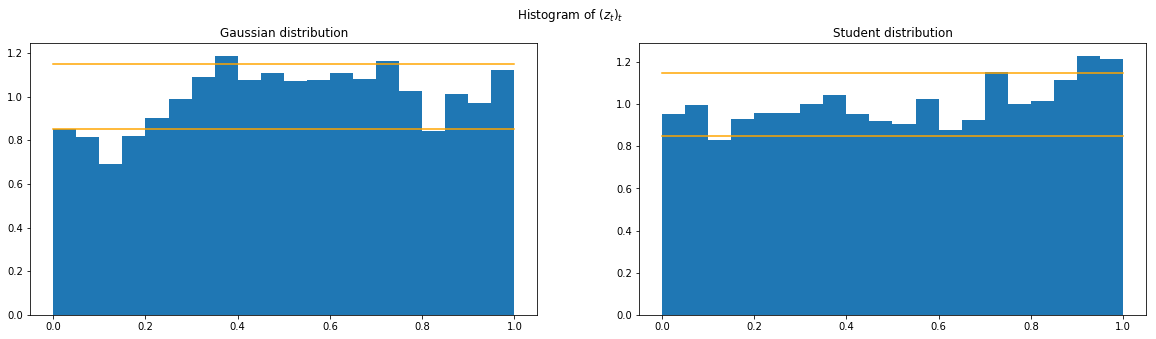

In [9]:
sigma2 = model.garch_filter(model.w,model.alpha,model.beta,ysandp_out_sample)
mu = model.arma_filter(model.phi,model.theta,ysandp_out_sample)
z_t = []
nu = model.df
for i in range(len(ysandp_out_sample)):
    z_t.append(stats.t.cdf(ysandp_out_sample[i] , df = model.df , loc = mu[i] , scale = pow(sigma2[i]* (model.df-2) / model.df,1/2)))
fig,ax = plt.subplots(1, 2,figsize=(20,5))
plt.suptitle("Histogram of $(z_t)_t$")
ax[0].hist(z_gauss,bins=20,density=True)
ax[0].plot([0,1],[1.15,1.15] , color = 'orange')
ax[0].plot([0,1],[0.85,0.85] , color = 'orange')
ax[0].title.set_text('Gaussian distribution')
ax[1].hist(z_t,bins=20,density=True)
ax[1].plot([0,1],[1.15,1.15] , color = 'orange')
ax[1].plot([0,1],[0.85,0.85] , color = 'orange')
ax[1].title.set_text('Student distribution')
plt.show()

In [10]:
z_test = z_t
stats.kstest(z_test,stats.uniform.cdf)

KstestResult(statistic=0.03691583291345568, pvalue=1.5905217349071285e-05)

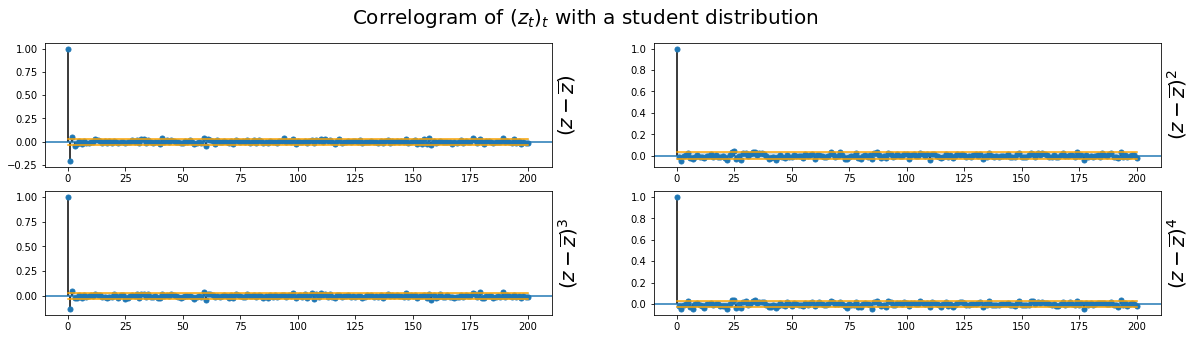

In [11]:
z_mean = sum(z_t)/len(z_t)
z1 = z_t-z_mean
z2 = pow(z_t-z_mean,2)
z3 = pow(z_t-z_mean,3)
z4 = pow(z_t-z_mean,4)
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(20,5))
plt.suptitle('Correlogram of $(z_t)_t$ with a student distribution',size=20)
plot_acf(z1,lags=200,ax=ax[0,0],title="")
ax[0,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,0].set_ylabel('$(z- \overline{z})$', fontsize = 20 )#ylabel
ax[0,0].yaxis.set_label_position("right")
plot_acf(z2,lags=200,ax=ax[0,1],title="")
ax[0,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,1].set_ylabel('$(z- \overline{z})^2$', fontsize = 20 )#ylabel
ax[0,1].yaxis.set_label_position("right")
plot_acf(z3,lags=200,ax=ax[1,0],title="")
ax[1,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,0].set_ylabel('$(z- \overline{z})^3$', fontsize = 20 )#ylabel
ax[1,0].yaxis.set_label_position("right")
plot_acf(z4,lags=200,ax=ax[1,1],title="")
ax[1,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,1].set_ylabel('$(z- \overline{z})^4$', fontsize = 20 )#ylabel
ax[1,1].yaxis.set_label_position("right")
plt.show()

The p-value of the kolmogorov test is not very high but the form of the histogram and correlogram remains good

#### We also try with a generalized normal distribution

In [12]:
model = ArmaGarch(qm=1,pv=1,qv=1,dist='generalize normal')
model.fit(ysandp_in_sample)
model.show()

                 ARMA(0,1)-GARCH(1,1)
Distribution          Generalize Normal
Beta                  1.46
Method                 Maximum Likelihood
Optimization method    Nelder-Mead
Sucess                 True
Log Likelihood         -3960.471790267085
AIC                    7930.94358053417
BIC                    7954.250615792217
                       Coeffs
--------------------Mean Model------------------
theta[0]   0.28523437499999993
-----------------Volatility Model---------------
omega      0.0131540902809113
alpha[0]   0.1115744837459417
beta[0]    0.8884254806223022


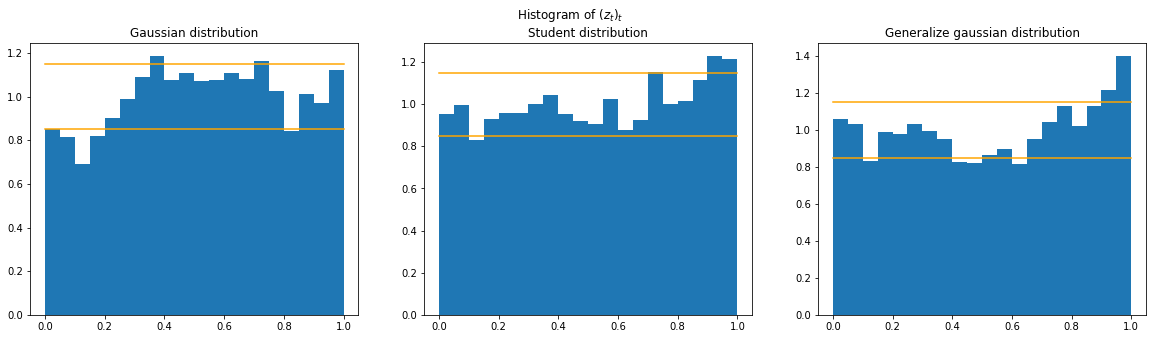

In [13]:
sigma2 = model.garch_filter(model.w,model.alpha,model.beta,ysandp_out_sample)
mu = model.arma_filter(model.phi,model.theta,ysandp_out_sample)
z_gennorm = []
nu = model.df
for i in range(len(ysandp_out_sample)):
    z_gennorm.append(stats.gennorm.cdf(ysandp_out_sample[i] , beta = model.gennorm_beta , loc = mu[i] , scale = pow(sigma2[i],1/2)))
fig,ax = plt.subplots(1, 3,figsize=(20,5))
plt.suptitle('Histogram of $(z_t)_t$')
ax[0].hist(z_gauss,bins=20,density=True)
ax[0].plot([0,1],[1.15,1.15] , color = 'orange')
ax[0].plot([0,1],[0.85,0.85] , color = 'orange')
ax[0].title.set_text('Gaussian distribution')
ax[1].hist(z_t,bins=20,density=True)
ax[1].plot([0,1],[1.15,1.15] , color = 'orange')
ax[1].plot([0,1],[0.85,0.85] , color = 'orange')
ax[1].title.set_text('Student distribution')
ax[2].hist(z_gennorm,bins=20,density=True)
ax[2].plot([0,1],[1.15,1.15] , color = 'orange')
ax[2].plot([0,1],[0.85,0.85] , color = 'orange')
ax[2].title.set_text('Generalize gaussian distribution')
plt.show()

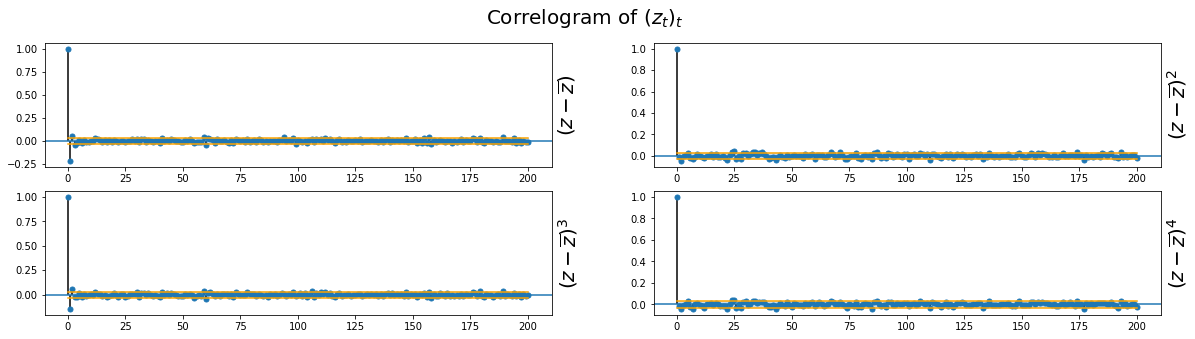

In [14]:
z_mean = sum(z_gennorm)/len(z_gennorm)
z1 = z_gennorm-z_mean
z2 = pow(z_gennorm-z_mean,2)
z3 = pow(z_gennorm-z_mean,3)
z4 = pow(z_gennorm-z_mean,4)
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(20,5))
plt.suptitle('Correlogram of $(z_t)_t$',size=20)
plot_acf(z1,lags=200,ax=ax[0,0],title="")
ax[0,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,0].set_ylabel('$(z- \overline{z})$', fontsize = 20 )#ylabel
ax[0,0].yaxis.set_label_position("right")
plot_acf(z2,lags=200,ax=ax[0,1],title="")
ax[0,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,1].set_ylabel('$(z- \overline{z})^2$', fontsize = 20 )#ylabel
ax[0,1].yaxis.set_label_position("right")
plot_acf(z3,lags=200,ax=ax[1,0],title="")
ax[1,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,0].set_ylabel('$(z- \overline{z})^3$', fontsize = 20 )#ylabel
ax[1,0].yaxis.set_label_position("right")
plot_acf(z4,lags=200,ax=ax[1,1],title="")
ax[1,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,1].set_ylabel('$(z- \overline{z})^4$', fontsize = 20 )#ylabel
ax[1,1].yaxis.set_label_position("right")
plt.show()

#### We finally try a skew normal to capture the effect of asymetry

In [15]:
model = ArmaGarch(qm=1,pv=1,qv=1,dist='skew normal')
model.fit(ysandp_in_sample)
model.show()

                 ARMA(0,1)-GARCH(1,1)
Distribution           Skew normal
Alpha                  0.05
Method                 Maximum Likelihood
Optimization method    Nelder-Mead
Sucess                 True
Log Likelihood         -3969.255200129231
AIC                    7948.510400258462
BIC                    7971.817435516509
                       Coeffs
--------------------Mean Model------------------
theta[0]   0.2555273437499999
-----------------Volatility Model---------------
omega      0.005477593601655326
alpha[0]   0.10241662026480233
beta[0]    0.8908613386796005


In [16]:
sigma2 = model.garch_filter(model.w,model.alpha,model.beta,ysandp_out_sample)
mu = model.arma_filter(model.phi,model.theta,ysandp_out_sample)
z_sk = [stats.norm.cdf(ysandp_out_sample[0],0,sigma2[0])]
for i in range(1,len(ysandp_out_sample)):
     z_sk.append(stats.skewnorm.cdf(ysandp_out_sample[i], model.skewnorm_alpha, scale=pow(sigma2[i],1/2)))

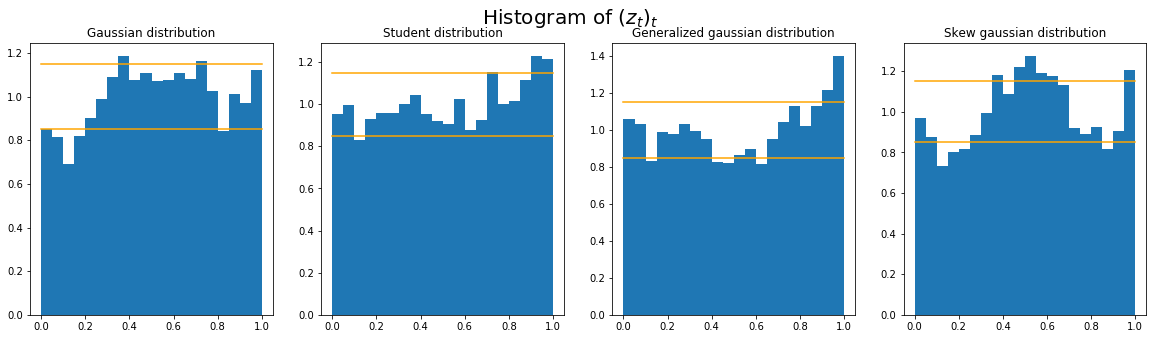

In [17]:
fig,ax = plt.subplots(1, 4,figsize=(20,5))
plt.suptitle("Histogram of $(z_t)_t$",size=20)
ax[0].hist(z_gauss,bins=20,density=True)
ax[0].plot([0,1],[1.15,1.15] , color = 'orange')
ax[0].plot([0,1],[0.85,0.85] , color = 'orange')
ax[0].title.set_text('Gaussian distribution')
ax[1].hist(z_t,bins=20,density=True)
ax[1].plot([0,1],[1.15,1.15] , color = 'orange')
ax[1].plot([0,1],[0.85,0.85] , color = 'orange')
ax[1].title.set_text('Student distribution')
ax[2].hist(z_gennorm,bins=20,density=True)
ax[2].plot([0,1],[1.15,1.15] , color = 'orange')
ax[2].plot([0,1],[0.85,0.85] , color = 'orange')
ax[2].title.set_text('Generalized gaussian distribution')
ax[3].hist(z_sk,bins=20,density=True)
ax[3].plot([0,1],[1.15,1.15] , color = 'orange')
ax[3].plot([0,1],[0.85,0.85] , color = 'orange')
ax[3].title.set_text('Skew gaussian distribution')
plt.show()

## Euro Stoxx 50

We also make an application on Euro Stoxx 50 data from https://www.stoxx.com/index-details?symbol=SX5T. It's from 1992 to today

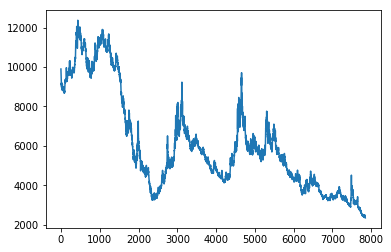

In [18]:
yeuro = []
count = 0
with open ('EUROXSTOXX50.txt', 'rt') as myfile:  
    for line in myfile:
        yeuro.append(float(line))
#yeuro = (yeuro - np.mean(yeuro))/pow(np.var(yeuro),1/2)
plt.plot(yeuro)
plt.show()

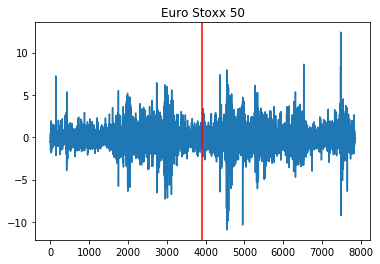

The size of training sample is 3900 and size of test sample is 3946


In [19]:
yeuro_var = []
for i in range(1,len(yeuro)):
    yeuro_var.append((yeuro[i]-yeuro[i-1])/yeuro[i-1]*100)
#yeuro_var = (yeuro_var - np.mean(yeuro_var))/pow(np.var(yeuro_var),1/2)
plt.plot(yeuro_var)
plt.title("Euro Stoxx 50")
plt.axvline(x=3900,color='red')
plt.show()
yeuro_in_sample = yeuro_var[:3900]
yeuro_out_sample = yeuro_var[3900:]
print('The size of training sample is',len(yeuro_in_sample),'and size of test sample is',len(yeuro_out_sample))

In [21]:
best = np.inf
param = []
for pm in [0,1,2]:
    for qm in [0,1,2]:
        for pv in [0,1,2]:
            for qv in [0,1,2]:
                model = ArmaGarch(pm=pm,qm=qm,pv=pv,qv=qv,dist='gaussian')
                model.fit(yeuro_in_sample)
                print("For ARMA(%i,%i)-GARCH(%i,%i) AIC is %f and BIC is %f" %(pm,qm,pv,qv,model.AIC,model.BIC))
                if (model.BIC < best):
                    param = [pm,qm,pv,qv]
                    best = model.BIC
print("Best model is ARMA(%d,%d)-GARCH(%d,%d)" %(param[0],param[1],param[2],param[3]))

For ARMA(0,0)-GARCH(0,0) AIC is 13340.807314 and BIC is 13353.344777
For ARMA(0,0)-GARCH(0,1) AIC is 14088.053064 and BIC is 14098.590528
For ARMA(0,0)-GARCH(0,2) AIC is 14093.647680 and BIC is 14110.453875
For ARMA(0,0)-GARCH(1,0) AIC is 12611.097409 and BIC is 12621.634872
For ARMA(0,0)-GARCH(1,1) AIC is 11432.676899 and BIC is 11449.483094
For ARMA(0,0)-GARCH(1,2) AIC is 11429.904494 and BIC is 11452.979422
For ARMA(0,0)-GARCH(2,0) AIC is 14021.178064 and BIC is 14037.984260
For ARMA(0,0)-GARCH(2,1) AIC is 11583.675169 and BIC is 11606.750096
For ARMA(0,0)-GARCH(2,2) AIC is 11328.030602 and BIC is 11357.374261
For ARMA(0,1)-GARCH(0,0) AIC is 13342.682816 and BIC is 13361.489011
For ARMA(0,1)-GARCH(0,1) AIC is 14090.083040 and BIC is 14106.889236
For ARMA(0,1)-GARCH(0,2) AIC is 14095.677982 and BIC is 14118.752909
For ARMA(0,1)-GARCH(1,0) AIC is 12612.653997 and BIC is 12629.460193
For ARMA(0,1)-GARCH(1,1) AIC is 11433.835609 and BIC is 11456.910536
For ARMA(0,1)-GARCH(1,2) AIC is 11

This time the best model regards to BIC criterion is $GARCH(2,2)$, so only a conditional variance effect

In [22]:
model = ArmaGarch(pv=2,qv=2,dist='gaussian' )
model.fit(yeuro_in_sample)
model.show()
sigma2 = model.garch_filter(model.w,model.alpha,model.beta,yeuro_out_sample)
mu = model.arma_filter(model.phi,model.theta,yeuro_out_sample)
z_gauss = []
nu = model.df
for i in range(len(yeuro_out_sample)):
    z_gauss.append(stats.norm.cdf(yeuro_out_sample[i],loc=mu[i], scale=pow(sigma2[i],1/2)))

                 ARMA(0,0)-GARCH(2,2)
Distribution           Normal
Standard deviation     0.98
Method                 Maximum Likelihood
Optimization method    Nelder-Mead
Sucess                 False
Log Likelihood         -5658.015300768578
AIC                    11328.030601537155
BIC                    11357.374260697743
                       Coeffs
-----------------Volatility Model---------------
omega      0.022329310002498007
alpha[0]   0.03587525069484386
alpha[1]   0.056245404416499334
beta[0]    0.7545595774433971
beta[1]    0.13941611792664338


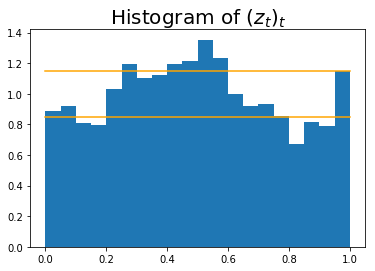

In [23]:
plt.figure()
plt.hist(z_gauss,bins=20,density=True)
plt.plot([0,1],[1.15,1.15] , color = 'orange')
plt.plot([0,1],[0.85,0.85] , color = 'orange')
plt.title("Histogram of $(z_t)_t$",size=20)
plt.show()

In [24]:
model = ArmaGarch(pv=2,qv=2,dist='student')
model.fit(yeuro_in_sample)
model.show()
sigma2 = model.garch_filter(model.w,model.alpha,model.beta,yeuro_out_sample)
mu = model.arma_filter(model.phi,model.theta,yeuro_out_sample)
z_t = []
nu = model.df
for i in range(len(yeuro_out_sample)):
    z_t.append(stats.t.cdf(yeuro_out_sample[i] , df = model.df , loc = mu[i] , scale =  pow(sigma2[i]* (nu-2) / nu,1/2)))

                 ARMA(0,0)-GARCH(2,2)
Distribution           Student
Degree of freedom      6
Method                 Maximum Likelihood
Optimization method    Nelder-Mead
Sucess                 True
Log Likelihood         -5571.390988829947
AIC                    11164.781977659894
BIC                    11225.46929598107
                       Coeffs
-----------------Volatility Model---------------
omega      0.01271650622175058
alpha[0]   0.03463121646664299
alpha[1]   0.06934018936033681
beta[0]    0.787582559626089
beta[1]    0.10818839476527395


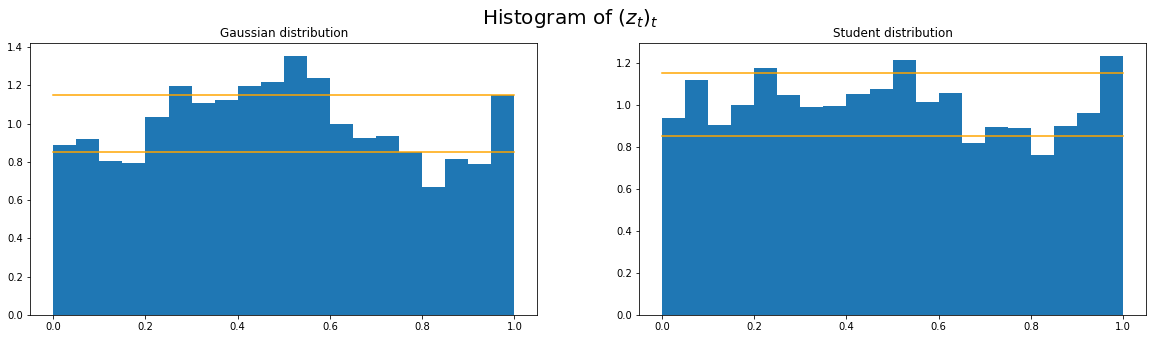

In [25]:
fig,ax = plt.subplots(1, 2,figsize=(20,5))
plt.suptitle("Histogram of $(z_t)_t$",size=20)
ax[0].hist(z_gauss,bins=20,density=True)
ax[0].plot([0,1],[1.15,1.15] , color = 'orange')
ax[0].plot([0,1],[0.85,0.85] , color = 'orange')
ax[0].title.set_text('Gaussian distribution')
ax[1].hist(z_t,bins=20,density=True)
ax[1].plot([0,1],[1.15,1.15] , color = 'orange')
ax[1].plot([0,1],[0.85,0.85] , color = 'orange')
ax[1].title.set_text('Student distribution')

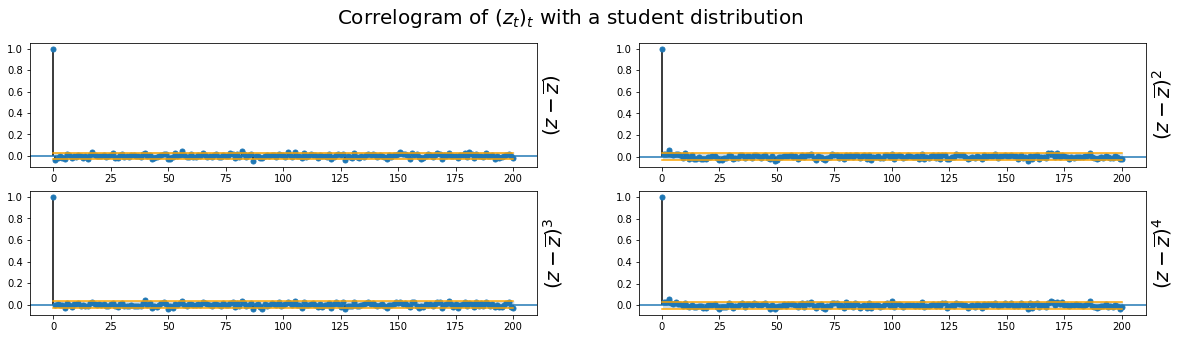

In [26]:
z_mean = sum(z_t)/len(z_t)
z1 = z_t-z_mean
z2 = pow(z_t-z_mean,2)
z3 = pow(z_t-z_mean,3)
z4 = pow(z_t-z_mean,4)
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(20,5))
plt.suptitle('Correlogram of $(z_t)_t$ with a student distribution',size=20)
plot_acf(z1,lags=200,ax=ax[0,0],title="")
ax[0,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,0].set_ylabel('$(z- \overline{z})$', fontsize = 20 )#ylabel
ax[0,0].yaxis.set_label_position("right")
plot_acf(z2,lags=200,ax=ax[0,1],title="")
ax[0,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[0,1].set_ylabel('$(z- \overline{z})^2$', fontsize = 20 )#ylabel
ax[0,1].yaxis.set_label_position("right")
plot_acf(z3,lags=200,ax=ax[1,0],title="")
ax[1,0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,0].set_ylabel('$(z- \overline{z})^3$', fontsize = 20 )#ylabel
ax[1,0].yaxis.set_label_position("right")
plot_acf(z4,lags=200,ax=ax[1,1],title="")
ax[1,1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1,1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
ax[1,1].set_ylabel('$(z- \overline{z})^4$', fontsize = 20 )#ylabel
ax[1,1].yaxis.set_label_position("right")
plt.show()